In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [0]:
## I am setting the path
path=Path('/content/drive/My Drive/bbc_train')

In [40]:
## checking path
path

PosixPath('/content/drive/My Drive/bbc_train')

In [0]:
path.ls()

In [0]:
labels=json.load(open(path/'bboxes.json', 'r'))

def get_y_fn(x): return path/'masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

In [47]:
labels.keys()

dict_keys(['images', 'annotations', 'type', 'categories'])

In [0]:
images, lbl_bbox = get_annotations(path/'bboxes.json')

In [49]:
len(images), len(lbl_bbox)

(1185, 1185)

In [50]:
images[:5]

['P2050936.jpg',
 'P2050922.jpg',
 'P2060163.jpg',
 'P2060003.jpg',
 'P2060017.jpg']

In [51]:
lbl_bbox[0]

[[[145.47435897435898,
   254.82692307692304,
   237.14102564102564,
   347.4551282051282]],
 ['ball']]

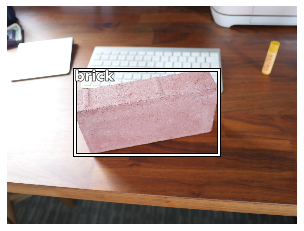

In [52]:
i=2
img = open_image(path/'images'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

In [0]:
src = (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))


In [0]:
labels=pd.read_csv(path/'classification_labels.csv')

In [42]:
labels.head()

,filename,label,label_index
0,P2050936.jpg,ball,2
1,P2050922.jpg,ball,2
2,P2060163.jpg,brick,1
3,P2060003.jpg,ball,2
4,P2060017.jpg,ball,2


In [0]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

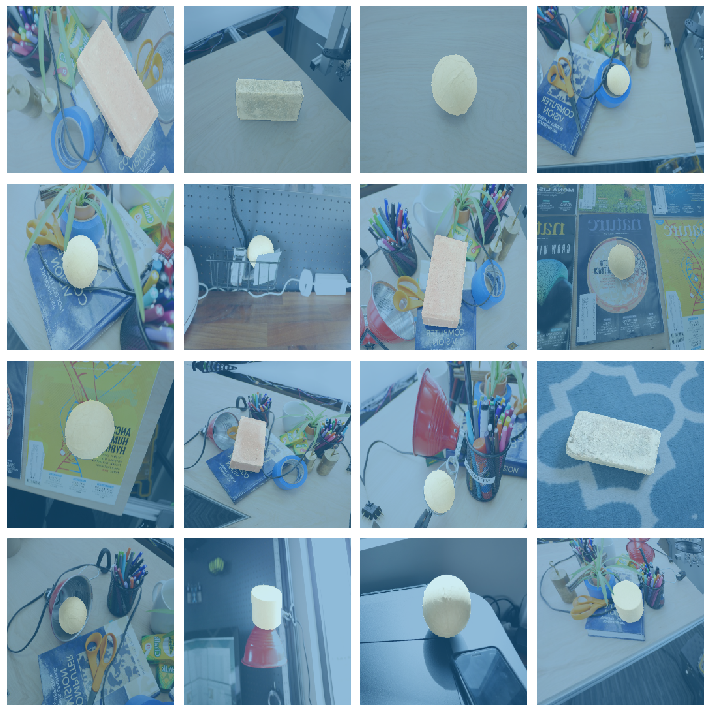

In [45]:
data.show_batch(figsize=(10,10))

In [0]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

In [0]:
def get_data(bs, size):

    src = ObjectItemList.from_folder(path/'images')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    
    return src.databunch(path = path, bs = bs, collate_fn = bb_pad_collate)


In [0]:
def my_accuracy(yhat, y):
    class_labels = torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(y.shape[0])]).to('cuda')
    return accuracy(yhat[0][:,4:], class_labels.view(-1))

def my_l1(yhat, y):
    #Extract bounding box from mask:
    bboxes = torch.zeros((y.shape[0], 4))
    for i in range(y.shape[0]):
        rows,cols = np.where(y[i, 0]!=0)
        bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])

    return nn.L1Loss()(yhat[0][:,:4], bboxes.to('cuda'))

def pixel_accuracy(yhat, y):
    y_ = y.squeeze(dim=1)
    yhat_ = yhat[1].argmax(dim=1)
    return (y_ == yhat_).sum().float()/y.numel()


In [0]:
def compute_corner_locations(y, im_shape=(256,256)):
    shape_vec=np.array(im_shape*2)
    bounds=((y+1)*shape_vec/2).ravel()
    corners=np.array([[bounds[1], bounds[0]], 
                      [bounds[3], bounds[0]],
                      [bounds[3], bounds[2]],
                      [bounds[1], bounds[2]],
                      [bounds[1], bounds[0]]])
    return corners

In [0]:
class MyLoss(nn.Module):
    def forward(self,yhat,y):
        class_labels=torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(y.shape[0])]) 
        bboxes=torch.zeros((y.shape[0], 4))
        for i in range(y.shape[0]):
            rows,cols= np.where(y[i, 0]!=0)
           
            bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])
        return (nn.CrossEntropyLoss()(yhat[0][:,4:] + (nn.L1Loss()(yhat[0][:,:4], bboxes.to('cuda'))) + (nn.CrossEntropyLoss()(yhat[1],y.squeeze(dim=1)))

In [0]:
  class MyHead(nn.Module):
      def __init__(self):
          super().__init__()

          self.detection_class = nn.Sequential(
                              AdaptiveConcatPool2d((4,4)),
                              Flatten(),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(16384,256), #2*512*4*4
                              nn.ReLU(),
                              nn.BatchNorm1d(256),
                              nn.Dropout(0.5),
                              nn.Linear(256,8))
          
          self.segmentation = nn.Sequential(conv_trans(512, 256), 
                            conv_trans(256, 128),
                            conv_trans(128, 64),
                            conv_trans(64, 32), 
                            nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))
      def forward(self,x):
          return self.detection_class(x), self.segmentation(x)
  

In [0]:
learn = cnn_learner(data, models.resnet34, custom_head=MyHead(), loss_func=MyLoss(), metrics=[my_accuracy, my_l1,pixel_accuracy])

In [54]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [0]:
learn.freeze()

In [37]:
lr=1e-2
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,127.960266,132.022873,0.877660,130.976349,0.918116,00:18
1,118.473335,99.485611,0.893617,98.879059,0.929907,00:18
2,62.999317,17.638783,0.920213,17.254009,0.958469,00:18
3,34.919189,13.961185,0.957447,13.756071,0.975163,00:18
4,23.542116,11.392992,0.946809,11.141268,0.974467,00:18
5,18.710325,10.236315,0.957447,10.028510,0.978799,00:18
6,16.595592,9.748977,0.946809,9.591512,0.978794,00:18
7,15.425896,9.711870,0.952128,9.542660,0.979869,00:18


In [0]:
learn.unfreeze()

In [39]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,14.360748,9.143767,0.952128,8.955948,0.978334,00:19
1,14.196025,9.115941,0.946809,8.907897,0.979963,00:18
2,13.894217,9.148092,0.968085,8.988101,0.980088,00:18
3,13.646220,8.826411,0.968085,8.696294,0.983129,00:18
4,13.136756,7.399116,0.973404,7.285831,0.984866,00:18
5,13.188971,6.858939,0.989362,6.783873,0.986396,00:18
6,12.831513,6.619575,0.989362,6.551465,0.986825,00:18
7,12.596818,6.503382,0.989362,6.437089,0.986927,00:18


In [0]:
learn.unfreeze()

In [44]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,12.174309,7.023256,0.989362,6.957246,0.986874,00:18
1,12.233242,6.278147,0.989362,6.206977,0.987006,00:18
2,12.232512,6.337989,0.989362,6.266505,0.987038,00:18
3,12.092359,6.609698,0.994681,6.544524,0.987600,00:18
4,12.338099,6.400211,0.994681,6.336763,0.987268,00:18
5,12.388126,6.072049,0.984043,6.006364,0.987700,00:18
6,12.110806,6.092133,0.989362,6.029374,0.987914,00:18
7,12.195166,6.207893,0.984043,6.141515,0.987993,00:19


In [0]:
learn.unfreeze()

In [57]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,12.176587,6.418739,0.989362,6.360021,0.988246,00:18
1,12.391551,7.293149,0.968085,7.180774,0.983167,00:19
2,12.494724,7.166874,0.984043,7.062089,0.986507,00:18
3,12.709207,7.132537,0.962766,6.995011,0.983689,00:19
4,12.670777,6.488992,0.978723,6.405966,0.985806,00:19
5,12.313790,5.796217,0.984043,5.710274,0.987526,00:19
6,12.237243,5.529409,0.984043,5.462478,0.988265,00:19
7,12.129109,5.329686,0.984043,5.264283,0.988290,00:19


In [0]:
learn.unfreeze()

In [59]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,11.922063,5.675100,0.989362,5.608551,0.988267,00:19
1,11.739599,5.675557,0.984043,5.598310,0.988807,00:19
2,11.862592,5.600988,0.984043,5.534569,0.987189,00:19
3,11.897576,5.589930,0.984043,5.530047,0.988618,00:19
4,11.984825,5.319026,0.984043,5.260789,0.989245,00:19
5,11.997871,5.175150,0.994681,5.116919,0.988910,00:19
6,11.712272,4.947490,0.994681,4.887930,0.989036,00:19
7,11.870187,5.402477,0.994681,5.342383,0.989166,00:19


In [0]:
learn.unfreeze()

In [72]:
lr=1e-4*1.2
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,my_accuracy,my_l1,pixel_accuracy,time
0,11.540359,5.050030,0.994681,4.987206,0.989196,00:19
1,12.049671,5.095457,0.994681,5.040114,0.989666,00:18
2,11.993976,5.314690,0.994681,5.256667,0.989817,00:19
3,11.900837,5.248186,0.984043,5.179450,0.990193,00:18
4,11.681174,5.056812,0.984043,4.992476,0.990062,00:18
5,11.582693,5.054197,0.978723,4.984142,0.989987,00:18
6,11.397460,4.607172,0.984043,4.540419,0.990100,00:18
7,11.895127,4.716269,0.994681,4.657292,0.990333,00:18


In [0]:
x,y = data.one_batch()

In [0]:
x_norm=normalize(x, torch.tensor(learn.data.stats[0]), 
                            torch.tensor(learn.data.stats[1]))


#Pass data into model:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    yhat=learn.model(x_norm.to(device))

In [0]:
learn.export()

In [65]:
yhat[1].shape

torch.Size([16, 4, 256, 256])

In [66]:
yhat[1]

tensor([[[[ 1.9531,  4.6136,  3.5347,  ...,  4.5881,  3.5199,  2.4317],
          [ 3.7766,  6.6675,  6.7799,  ...,  6.5189,  7.4216,  3.7944],
          [ 3.7645,  7.0248,  6.6219,  ...,  7.2647,  6.4985,  4.5054],
          ...,
          [ 3.9833,  6.5856,  7.2923,  ...,  6.5587,  7.5960,  3.7856],
          [ 3.7669,  7.6073,  6.7449,  ...,  7.3194,  6.4176,  4.6204],
          [ 1.8216,  3.4495,  3.7331,  ...,  3.4699,  3.7179,  1.9496]],

         [[-1.1069, -1.1079, -2.0613,  ..., -1.0481, -2.0634, -0.3392],
          [-1.5511, -3.0814, -2.9231,  ..., -2.8994, -2.7633, -2.4249],
          [-1.1860, -2.9463, -3.1595,  ..., -2.8579, -3.5384, -1.6038],
          ...,
          [-1.7454, -3.4136, -3.1903,  ..., -2.8289, -2.6994, -2.6267],
          [-1.3460, -3.2910, -3.6172,  ..., -2.6203, -3.3446, -1.4891],
          [-0.8577, -1.4010, -1.6192,  ..., -1.3361, -1.4700, -0.8300]],

         [[-0.8742, -1.6577, -2.3682,  ..., -1.6856, -2.2428, -0.9515],
          [-2.0739, -4.5311, -

In [0]:
segmented_image=yhat[1].argmax(1)

In [68]:
segmented_image.shape

torch.Size([16, 256, 256])

In [69]:
path

PosixPath('/content/drive/My Drive/bbc_train')